### **1.1 Preparation**

Environment installation and data download

In [1]:
# !pip3 -qq install torch==1.1
# !pip uninstall -y nltk
# !pip -qq install nltk==3.8
# !pip -qq install gensim
# !pip -qq install bokeh==3.2.0

# we have already download everything so no need
# !wget -O quora.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1ERtxpdWOgGQ3HOigqAMHTJjmOE_tWvoF"
# !unzip -o quora.zip

import nltk
# nltk.download('punkt')
import time
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from IPython.display import clear_output
%matplotlib inline
np.random.seed(42)

import pandas as pd
from nltk.tokenize import word_tokenize
from tqdm import tqdm


1. Tokenize and lower-case texts.

In [2]:
quora_data = pd.read_csv('train.csv')

quora_data.question1 = quora_data.question1.replace(np.nan, '', regex=True)
quora_data.question2 = quora_data.question2.replace(np.nan, '', regex=True)

texts = list(pd.concat([quora_data.question1, quora_data.question2]).unique())
texts = texts[:50000] # Accelerated operation
print(len(texts))

tokenized_texts = [word_tokenize(text.lower()) for text in tqdm(texts)]

assert len(tokenized_texts) == len(texts)
assert isinstance(tokenized_texts[0], list)
assert isinstance(tokenized_texts[0][0], str)

50000


100%|██████████| 50000/50000 [00:02<00:00, 24604.83it/s]


In [3]:
tokenized_texts[0]

['what',
 'is',
 'the',
 'step',
 'by',
 'step',
 'guide',
 'to',
 'invest',
 'in',
 'share',
 'market',
 'in',
 'india',
 '?']

2. Collect the indices of the words:

In [4]:
from collections import Counter

MIN_COUNT = 5

words_counter = Counter(token for tokens in tokenized_texts for token in tokens)
word2index = {
    '<unk>': 0
}

for word, count in words_counter.most_common():
    if count < MIN_COUNT:
        break

    word2index[word] = len(word2index)

index2word = [word for word, _ in sorted(word2index.items(), key=lambda x: x[1])]

print('Vocabulary size:', len(word2index))
print('Tokens count:', sum(len(tokens) for tokens in tokenized_texts))
print('Unknown tokens appeared:', sum(1 for tokens in tokenized_texts for token in tokens if token not in word2index))
print('Most freq words:', index2word[1:21])

Vocabulary size: 7226
Tokens count: 623563
Unknown tokens appeared: 35607
Most freq words: ['?', 'the', 'what', 'is', 'how', 'i', 'a', 'to', 'in', 'do', 'of', 'are', 'and', 'can', 'for', ',', 'you', 'why', 'it', 'best']


3. collect the context words

First of all, we need to collect all the contexts from our corpus.

In [5]:
def build_contexts(tokenized_texts, window_size):
    contexts = []
    for tokens in tokenized_texts:
        for i in range(len(tokens)):
            central_word = tokens[i]
            context = [tokens[i + delta] for delta in range(-window_size, window_size + 1)
                       if delta != 0 and i + delta >= 0 and i + delta < len(tokens)]

            contexts.append((central_word, context))

    return contexts

contexts = build_contexts(tokenized_texts, window_size=2)

Check, what you got:

In [6]:
contexts[:5]

[('what', ['is', 'the']),
 ('is', ['what', 'the', 'step']),
 ('the', ['what', 'is', 'step', 'by']),
 ('step', ['is', 'the', 'by', 'step']),
 ('by', ['the', 'step', 'step', 'guide'])]

4. Convert to indices

Let's convert words to indices:

In [7]:
contexts = [(word2index.get(central_word, 0), [word2index.get(word, 0) for word in context])
            for central_word, context in contexts]

### **1.2 Skip-Gram Word2vec**

Word2vec is actually a set of models used to build word embeddings.

We are going to start with the *skip-gram model*.

It's a very simple neural network with just two layers. It aims to build word vectors that encode information about the co-occurring words:  
![](https://i.ibb.co/nL0LLD2/Word2vec-Example.jpg)  

More precisely, it models the probabilities $\{P(w_{c+j}|w_c):  j = c-k, ..., c+k, j \neq c\}$, where $k$ is the context window size, $c$ is index of the central word (which embedding we are trying to optimize).

The learnable parameters of the model are following: matrix $U$ (embeddings' matrix that is used in all downstream tasks. In gensim it's called `syn0`) and matrix $V$ - output layer of the model (in gensim it's called `syn1`).

Two vectors correspond to each word: a row in $U$ and a column in $V$. That is $U \in \mathbb{R}^{|V|, d}$ and $V \in \mathbb{R}^{d, |V|}$, where $d$ is embedding size and $|V|$ is the vocabulary size.

As a result, the neural network looks this way:  
![skip-gram](https://i.ibb.co/F54XzDC/SkipGram.png)

What's going on and how it is connected to probability and word context?

Well, the word is mapped to its embedding $u_c$. Then this embedding is multiplied to matrix $V$.

As a result, we obtain the set of scores $\{v_j^T u_c : j \in {0, \ldots, |V|}\}$. Each corresponds to the similarity between the word $w_j$ vector and our word vector. It's very similar to the cosine similarity we calculated in the previous lesson, but without normalization.

This similarities show how likely $w_j$ can be in context of word $w_c$. That means, that they can be converted to probability using the softmax function:
$$P(w_j | w_c) = \frac{\exp(v_{j}^T u_c)}{\sum_{i=1}^{|V|} \exp(v_i^T u_c)}.$$

So for each word we calculate such probability distribution over our vocabulary. It's shown in using blue bars in the picture above. More likely word - bluer is the corresponding cell.

The model learns to distribute the probabilities between the co-occuring words for the given one. We'll use cross-entropy loss for it:
$$-\sum_{-k \leq j \leq k, j \neq 0} \log \frac{\exp(v_{c+j}^T u_c)}{\sum_{i=1}^{|V|} \exp(v_i^T u_c)} \to \min_{U, V}.$$

For instance, for the sample from the picture model will be penalized if it outputs a low probability of word `over`.

Please, notice that we calculate the similarity between vectors from different vector spaces. $u_c$ is the vector from the input embeddings and $v_j$ is the vector from the output embeddings. A high similarity between them means that they co-occur frequently, not that they are similar in the syntactic role or their semantics.

On the other hand, the similarity between $u_k$ and $u_m$ means that their output distributions are similar. And that means exactly that the similarity of the count vectors we discussed before and also most probably means their syntactic or semantic similarity.

Check this demo to understand what's going on in more depth: [https://ronxin.github.io/wevi/](https://ronxin.github.io/wevi/).

Let's implement it now!

1. **Batches Generations**

Neural networks are optimized using stochastic gradient descent methods. This requires a batch generator, a function that produces samples for optimizing the neural network.

**Implementation of a Batch Generator:**

In [8]:
import random

def make_skip_gram_batches_iter(contexts, window_size, num_skips, batch_size):

    '''
    params 含义
    - contexts: 原始数据，假设为 (central_word<str>, context_words<tuple>) 的列表
    - window_size: 上下文窗口半径（总窗口大小为 2 * window_size）
    - num_skips: 每个中心词sample的上下文词的数量（每个中心词生成 num_skips 个样本）,2, 每个中心词在2*window_size的范围内随机采样num_skips个上下文词，因此你可以在最后生成的batch中观察到，tokens总是重复num_skips遍
    - batch_size: 每个批次的总样本数, 32

    assert 检查
    - batch_size 必须是 num_skips 的倍数，保证每个中心词生成的样本能均匀分配到批次中。
    - num_skips 不能超过总上下文词数量（2 * window_size）。

    '''
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * window_size

    central_words = [word for word, context in contexts if len(context) == 2 * window_size and word != 0]
    contexts = [context for word, context in contexts if len(context) == 2 * window_size and word != 0]

    batch_size = int(batch_size / num_skips)
    batches_count = int(math.ceil(len(contexts) / batch_size))

    print('Initializing batches generator with {} batches per epoch'.format(batches_count))

    indices = np.arange(len(contexts))
    np.random.shuffle(indices)

    for i in range(batches_count):
        batch_begin, batch_end = i * batch_size, min((i + 1) * batch_size, len(contexts))
        batch_indices = indices[batch_begin: batch_end]

        batch_data, batch_labels = [], []

        for data_ind in batch_indices:
            central_word, context = central_words[data_ind], contexts[data_ind]

            words_to_use = random.sample(context, num_skips)
            batch_data.extend([central_word] * num_skips)
            batch_labels.extend(words_to_use)
        yield {
            'tokens': torch.LongTensor(batch_data),
            'labels': torch.LongTensor(batch_labels)
        }

Check it:

In [11]:
batch = next(make_skip_gram_batches_iter(contexts, window_size=2, num_skips=2, batch_size=32))

batch['tokens'].shape#32
batch

Initializing batches generator with 24760 batches per epoch


{'tokens': tensor([ 592,  592,    3,    3,    6,    6,   24,   24, 2061, 2061,    9,    9,
          773,  773,  528,  528,   21,   21,   66,   66,    8,    8,   70,   70,
           11,   11,    8,    8,    2,    2, 1847, 1847]),
 'labels': tensor([  17,   28,  132,   16,  763,   62,    9,    1,    2,   11,    1,   39,
           60,   15,   46, 1312, 3245, 1925,  478,  478,  574,  156,   10,   92,
            2,   20,   86,   30,   35,   15,  169,  408])}

2. **Model**

Here is the model implementation of skip-gram model, which has only two layers of neural networks.

In [8]:
class Skip_Gram_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.out_layer = nn.Linear(embedding_dim, vocab_size)

    def forward(self, inputs):
        embedded = self.embeddings(inputs)
        out = self.out_layer(embedded)
        return out

3. **Training**

In [9]:
# Here are the hyperparameters you can adjust
embedding_dim = 32
learning_rate = 0.001
epoch_num = 4
batch_size = 128

# Initialization Model
model = Skip_Gram_Model(len(word2index),embedding_dim)
# Getting model to GPU
model.cuda()
# Define the loss function
criterion = nn.CrossEntropyLoss()
# use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


loss_every_nsteps = 3000
total_loss = 0
start_time = time.time()
global_step = 0

for ep in range(epoch_num):
  for step, batch in enumerate(make_skip_gram_batches_iter(contexts, window_size=2, num_skips=4, batch_size=batch_size)):
      global_step += 1

      # Getting data to the GPU.
      tokens, labels = batch['tokens'].cuda(), batch['labels'].cuda()

      # make forward pass
      logits = model(tokens)

      # make backward pass
      loss = criterion(logits, labels)
      loss.backward()

      # apply optimizer
      optimizer.step()

      # zero grads
      optimizer.zero_grad()

      total_loss += loss.item()

      if global_step != 0 and global_step % loss_every_nsteps == 0:
          print("Epoch = {}, Step = {}, Avg Loss = {:.4f}, Time = {:.2f}s".format(ep, step, total_loss / loss_every_nsteps,
                                                                      time.time() - start_time))
          total_loss = 0
          start_time = time.time()

Initializing batches generator with 12380 batches per epoch
Epoch = 0, Step = 2999, Avg Loss = 7.1937, Time = 4.35s
Epoch = 0, Step = 5999, Avg Loss = 6.2948, Time = 3.53s
Epoch = 0, Step = 8999, Avg Loss = 6.1401, Time = 3.78s
Epoch = 0, Step = 11999, Avg Loss = 6.0557, Time = 3.66s
Initializing batches generator with 12380 batches per epoch
Epoch = 1, Step = 2619, Avg Loss = 5.9658, Time = 3.62s
Epoch = 1, Step = 5619, Avg Loss = 5.9406, Time = 3.64s
Epoch = 1, Step = 8619, Avg Loss = 5.9266, Time = 3.82s
Epoch = 1, Step = 11619, Avg Loss = 5.9030, Time = 3.54s
Initializing batches generator with 12380 batches per epoch
Epoch = 2, Step = 2239, Avg Loss = 5.8492, Time = 3.79s
Epoch = 2, Step = 5239, Avg Loss = 5.8443, Time = 3.94s
Epoch = 2, Step = 8239, Avg Loss = 5.8428, Time = 3.56s
Epoch = 2, Step = 11239, Avg Loss = 5.8351, Time = 3.54s
Initializing batches generator with 12380 batches per epoch
Epoch = 3, Step = 1859, Avg Loss = 5.8010, Time = 5.17s
Epoch = 3, Step = 4859, Avg L

**Obtaining word embeddings**

Word embeddings are contained within the embeddings layer of the model. We just need to move them from the GPU to the CPU and convert them to a numpy array.

In [10]:
embeddings_skipgram = model.embeddings.weight.data.cpu().numpy()

**Implementing a word similarity search algorithm**

Let's check how adequate are similarities that the model learnt.

In [11]:
from sklearn.metrics.pairwise import cosine_similarity

def most_similar(embeddings, index2word, word2index, word):
    word_emb = embeddings[word2index[word]]

    similarities = cosine_similarity([word_emb], embeddings)[0]
    top10 = np.argsort(similarities)[-10:]

    return [index2word[index] for index in reversed(top10)]

most_similar(embeddings_skipgram, index2word, word2index, 'my')

['my',
 'forever',
 'your',
 'instagram',
 'them',
 'her',
 'spain',
 'their',
 'focus',
 'password']

**Visualization of word embeddings**

In [12]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook

from sklearn.manifold import TSNE
from sklearn.preprocessing import scale


def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    output_notebook()

    if isinstance(color, str):
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show:
        pl.show(fig)
    return fig


def get_tsne_projection(word_vectors):
    tsne = TSNE(n_components=2, verbose=1)
    return scale(tsne.fit_transform(word_vectors))


def visualize_embeddings(embeddings, index2word, word_count):
    word_vectors = embeddings[1: word_count + 1]
    words = index2word[1: word_count + 1]

    word_tsne = get_tsne_projection(word_vectors)
    draw_vectors(word_tsne[:, 0], word_tsne[:, 1], color='blue', token=words)


visualize_embeddings(embeddings_skipgram, index2word, 100)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.042s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 3.058792
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.527149
[t-SNE] KL divergence after 950 iterations: 0.617247


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


**Advantages**:

- Captures semantic relationships effectively.
- Efficient for large datasets.
- Provides meaningful word representations.

**Disadvantages**:

- May struggle with rare words.
- Ignores word order.

## 1.3 GloVe (Global Vectors for Word Representation)

Global Vectors for Word Representation (GloVe) is a powerful word embedding technique that captures the semantic relationships between words by considering their co-occurrence probabilities within a corpus. The key to GloVe’s effectiveness lies in the construction of a word-context matrix and the subsequent factorization process.

Let’s consider a simplified example. Assume we have the following sentences in our corpus:

    “Word embeddings capture semantic meanings.”
    “GloVe is an impactful word embedding model.”

The word-context matrix might look like this:

![](https://miro.medium.com/v2/resize:fit:1354/format:webp/1*JZ4w_OxwGkt_W-814LB9Xw.png)

Here, each row and column corresponds to a unique word in the corpus, and the values in the cells represent how often these words appear together within a certain context window.

**Advantages**:

- Efficiently captures global statistics of the corpus.
- Good at representing both semantic and syntactic relationships.
- Effective in capturing word analogies.

**Disadvantages**:

- Requires more memory for storing co-occurrence matrices.
- Less effective with very small corpora.

In [16]:
import gensim.downloader as api
#GloVe
glove_model = api.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 376.1/376.1MB downloaded


## 1.4 FastText

FastText is an advanced word embedding technique developed by Facebook AI Research (FAIR) that extends the Word2Vec model. Unlike Word2Vec, FastText not only considers whole words but also **incorporates subword information** — parts of words like n-grams. This approach enables the handling of morphologically rich languages and captures information about word structure more effectively.


FastText represents each word as a bag of character n-grams in addition to the whole word itself. This means that the word “apple” is represented by the word itself and its constituent n-grams like “ap”, “pp”, “pl”, “le”, etc. This approach helps capture the meanings of shorter words and affords a better understanding of suffixes and prefixes.

In [20]:
# FastText
fasttext_model = api.load("fasttext-wiki-news-subwords-300")

[==================================================] 100.0% 958.5/958.4MB downloaded


**Advantages**:

- Better representation of rare words.
- Capable of handling out-of-vocabulary words.
- Richer word representations due to subword information.

**Disadvantages**:

- Increased model size due to n-gram information.
- Longer training times compared to Word2Vec.

## 1.5 The comparison between Word2Vec,GloVe and FastText.

In [21]:
import numpy as np
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity
import torch

This text includes:
- Common words (such as “quick”, “king”)
- Low-frequency words (such as “serendipity”)
- Out-of-vocabulary words (assuming “serendipity” has not appeared in the model before)
- Polysemous words (such as “king”, which can refer to a monarch or a chess piece)

In [22]:
# Example text
text = "The quick brown fox jumps over the lazy dog. The king rules the kingdom with wisdom. The word 'serendipity' is hard to spell."
words = ["quick", "king", "serendipity", "rules", "wisdom"]

In [25]:
# Get the word embeddings dictionary for SkipGram model
# Assuming embedding_skipgram is a torch tensor of shape (vocab_size, embedding_dim)
# word2index is a dictionary {word: index}, we can use it to get the word embeddings
skipgram_model = {word: embeddings_skipgram[idx] for word, idx in word2index.items()}

In [26]:
# Function to get word vectors
def get_vectors(model, words, model_type="skipgram"):
    vectors = []
    for word in words:
        if model_type == "skipgram":
            # For the SkipGram model, fetch the vector from the dictionary
            vector = model.get(word, None)  # Returns None if the word is not in the model
        else:
            try:
                vector = model[word]  # For GloVe and FastText
            except KeyError:
                vector = None  # Returns None if the word is not in the model
        vectors.append(vector)
    return vectors

# Function to compare cosine similarity between two vectors
def compare_similarity(vector1, vector2):
    if vector1 is None or vector2 is None:
        return None
    return cosine_similarity([vector1], [vector2])[0][0]

In [27]:
# Get word vectors for SkipGram, GloVe, and FastText models
skipgram_vectors = get_vectors(skipgram_model, words, model_type="skipgram")
glove_vectors = get_vectors(glove_model, words, model_type="glove")
fasttext_vectors = get_vectors(fasttext_model, words, model_type="fasttext")

Skip-gram return None because they are unable to handle out-of-vocabulary (OOV) words.

FastText, on the other hand,return a vector because it can handle OOV words by leveraging subword information.

In [31]:
# Compare the handling of low-frequency and out-of-vocabulary words：serendipity
serendipity_skipgram = skipgram_vectors[2]
serendipity_glove = glove_vectors[2]
serendipity_fasttext = fasttext_vectors[2]
print("Skip-gram (serendipity):", serendipity_skipgram)
print("GloVe (serendipity):", serendipity_glove)
print("FastText (serendipity):", serendipity_fasttext)

Skip-gram (serendipity): None
GloVe (serendipity): [ 0.18632   -0.34564    0.08389   -0.0088622  0.29216   -0.30842
  0.1446    -0.28246   -0.3814     0.17972    0.56072   -0.061665
 -0.14916    0.5461    -0.18552    0.63468   -0.09079   -0.47448
 -0.090303   0.77264   -0.39216    0.21172   -0.64588   -0.35832
  0.1424     0.68727    0.094841   0.10264   -0.20581    0.13369
  0.1335    -0.32181   -0.18035    0.060461   0.22884    0.25557
 -0.34548    0.18665    0.41418   -0.31108    0.3044     0.046528
 -0.021619   0.029792  -0.1386     0.016738   0.76186    0.082857
 -0.52825   -0.088613   0.0039659 -0.16441    0.049685   0.32602
 -0.13568   -0.0074606  0.22342    0.0017904  0.26966   -0.056631
  0.095477   0.15218    0.13187   -0.55669    0.55745    0.25169
  0.33585   -0.38694   -0.44972    0.3091    -0.069153   0.14882
  0.38556    0.1067    -0.31081    0.17787    0.23894    0.0087298
  0.57065   -0.29811   -0.2857     0.38242    0.056624   0.35403
  0.32367    0.23742    0.14528  

In [40]:
# Compare the representation of polysemy (e.g., "king")
king_skipgram = skipgram_vectors[1]
king_glove = glove_vectors[1]
king_fasttext = fasttext_vectors[1]

print("Skip-gram (king):", king_skipgram)
print("GloVe (king):", king_glove)
print("FastText (king):", king_fasttext)

Skip-gram (king): [ 0.31628785 -0.760931    0.8189545   0.91609496 -0.08077557 -1.026855
  0.9565246  -1.5333086  -0.8491853   1.2783899  -0.20191586 -0.5709858
 -1.0252635  -0.07605202  1.5680606   0.7796275  -0.08226055  1.0603969
  0.65367943 -0.618313    0.13778627  0.30875954 -1.1437807   1.0806786
  0.3334001   1.6914557  -1.3188773   0.15517178 -0.4365917   1.0445077
 -0.49070135  0.6228756   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          

In [33]:
# Compare the ability to capture contextual relationships
queen_skipgram = skipgram_model.get("queen", None)
queen_glove = glove_model["queen"]
queen_fasttext = fasttext_model["queen"]

king_queen_skipgram = compare_similarity(king_skipgram, queen_skipgram)
king_queen_glove = compare_similarity(king_glove, queen_glove)
king_queen_fasttext = compare_similarity(king_fasttext, queen_fasttext)

print("Skip-gram (king vs queen):", king_queen_skipgram)
print("GloVe (king vs queen):", king_queen_glove)
print("FastText (king vs queen):", king_queen_fasttext)

from sklearn.metrics.pairwise import cosine_similarity


Skip-gram (king vs queen): 0.08476952
GloVe (king vs queen): 0.63364697
FastText (king vs queen): 0.7704246


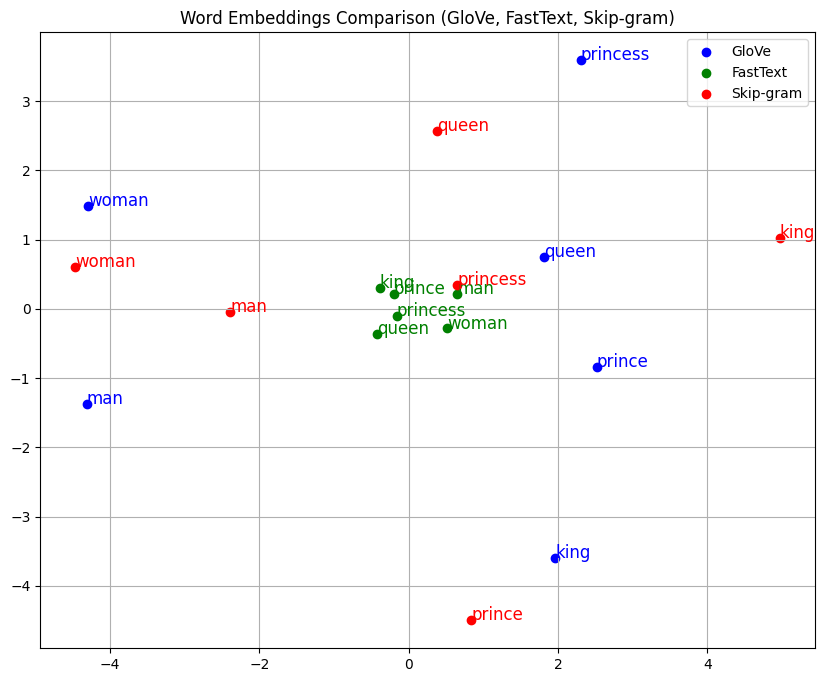

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# List of words to analyze
words = ['king', 'queen', 'man', 'woman', 'prince', 'princess']

# Get word vectors from GloVe model
glove_vectors = [glove_model[word] for word in words]

# Get word vectors from FastText model
fasttext_vectors = [fasttext_model[word] for word in words]

# Get word vectors from Skip-gram model, skipping words not found in the model
skipgram_vectors = []
for word in words:
    if word in skipgram_model:
        skipgram_vectors.append(skipgram_model[word])
    else:
        skipgram_vectors.append(np.zeros(300))  # Use a zero vector if word not found

# Normalize all vectors to the same size for PCA (e.g., by truncating or padding)
max_len = max([len(vec) for vec in glove_vectors + fasttext_vectors + skipgram_vectors])
glove_vectors = [np.pad(vec, (0, max_len - len(vec))) for vec in glove_vectors]
fasttext_vectors = [np.pad(vec, (0, max_len - len(vec))) for vec in fasttext_vectors]
skipgram_vectors = [np.pad(vec, (0, max_len - len(vec))) for vec in skipgram_vectors]

# Reduce the dimensionality of word vectors to 2D using PCA
pca = PCA(n_components=2)
glove_pca = pca.fit_transform(glove_vectors)
fasttext_pca = pca.fit_transform(fasttext_vectors)
skipgram_pca = pca.fit_transform(skipgram_vectors)

# Visualize the word embeddings
plt.figure(figsize=(10, 8))

# Plot GloVe word vectors
plt.scatter(glove_pca[:, 0], glove_pca[:, 1], label='GloVe', color='blue')
for i, word in enumerate(words):
    plt.text(glove_pca[i, 0], glove_pca[i, 1], word, color='blue', fontsize=12)

# Plot FastText word vectors
plt.scatter(fasttext_pca[:, 0], fasttext_pca[:, 1], label='FastText', color='green')
for i, word in enumerate(words):
    plt.text(fasttext_pca[i, 0], fasttext_pca[i, 1], word, color='green', fontsize=12)

# Plot Skip-gram word vectors
plt.scatter(skipgram_pca[:, 0], skipgram_pca[:, 1], label='Skip-gram', color='red')
for i, word in enumerate(words):
    plt.text(skipgram_pca[i, 0], skipgram_pca[i, 1], word, color='red', fontsize=12)

# Set plot attributes
plt.legend()
plt.title('Word Embeddings Comparison (GloVe, FastText, Skip-gram)')
plt.grid(True)
plt.show()


**GloVe (in blue)**:
The word vectors from the GloVe model are more dispersed in the diagram but still show some semantic relevance. For instance, "man" and "woman" are relatively close in space, indicating a semantic relationship based on gender.
"King" and "queen" as well as "prince" and "princess" also show proximity, suggesting their semantic relatedness.

**FastText (in green)**:
The word vectors from the FastText model are clustered more tightly together in the diagram, demonstrating closer semantic relationships. For example, "man" and "woman" as well as "king" and "queen" are much closer in distance, indicating stronger semantic proximity.
This tight clustering may suggest that FastText performs better at capturing subtle differences between words since it considers subword information.

**Skip-gram (in red)**:
The word vectors from the Skip-gram model are more dispersed but still exhibit some semantic relevance. "Man" and "woman" as well as "king" and "queen" are relatively close in space.
Compared to GloVe and FastText, the distribution of Skip-gram's word vectors might rely more on contextual information, and thus, it might not perform as well as the other models in capturing semantic relationships in some cases.

Overall, all three models have the capability to capture semantic relationships between words, but they differ in the distribution and clustering of word vectors. GloVe and Skip-gram have more dispersed word vector distributions, while FastText's vectors are more tightly clustered, showing stronger semantic relevance. These differences may be related to the training methods and the way word vectors are generated by each model.

## 1.6 Comparison of Memory and Computational Overheads: Word2Vec, GloVe, and FastText

---

### **1. Memory Overhead**

### **(1) Word2Vec (Skip-Gram)**
- **Parameters**: Only the embedding matrix.  
  $\text{Memory} = V \times d$  
  - $V$: Vocabulary size, $d$: Embedding dimension.

### **(2) GloVe**
- **Parameters**: Embeddings + biases + co-occurrence matrix (preprocessing).  
  $\text{Memory} = 2 \times V \times d + 2 \times V + \text{Co-occurrence Matrix}$  
  - Co-occurrence matrix uses sparse storage (e.g., hash tables).

### **(3) FastText**
- **Parameters**: Subword embeddings + word embeddings.  
  $\text{Memory} = (V + S) \times d$  
  - $S$: Number of subwords (e.g., 3-6 character n-grams).

---

### **2. Computational Overhead**

### **(1) Word2Vec (Skip-Gram)**
- **Complexity**:  
  $O(T \times (C + K) \times d)$  
  - $T$: Total tokens, $C$: Window size, $K$: Negative samples.

### **(2) GloVe**
- **Complexity**:  
  $O(N \times d)$  
  - $N$: Non-zero co-occurrence pairs.

### **(3) FastText**
- **Complexity**:  
  $O(T \times (B + C) \times d)$  
  - $B$: Subwords per word (typically 3-6).

---

### **3. Example with Parameters**
Assume:  
- $V = 10^4$, $d = 300$, $T = 10^6$, $C = 5$, $K = 5$, $S = 10^5$, $N = 10^7$.

### **Memory Overhead**
| Model      | Calculation                      | Memory (float32) |
|------------|-----------------------------------|------------------|
| Word2Vec   | $10^4 \times 300$                 | 11.4 MB          |
| GloVe      | $2 \times 10^4 \times 300 + 2 \times 10^4 + 10^7$ | 23.6 MB |
| FastText   | $(10^4 + 10^5) \times 300$       | 125.8 MB         |

### **Computational Overhead**
| Model      | Calculation                      | Operations       |
|------------|-----------------------------------|------------------|
| Word2Vec   | $10^6 \times (5 + 5) \times 300$  | $3 \times 10^9$  |
| GloVe      | $10^7 \times 300$                 | $3 \times 10^9$  |
| FastText   | $10^6 \times (5 + 5) \times 300$  | $3 \times 10^9$  |

---

### **4. Summary**
| Metric          | Word2Vec         | GloVe            | FastText         |
|-----------------|------------------|------------------|------------------|
| **Memory**      | Lowest (11.4 MB) | Moderate (23.6 MB)| Highest (125.8 MB)|
| **Computation** | Moderate         | Moderate         | Highest          |
| **Use Case**    | General semantics| Co-occurrence    | Morphology-rich languages |

- **Memory-sensitive**: Prefer Word2Vec or GloVe.  
- **Morphology-rich languages**: FastText excels.  
- **Balanced choice**: GloVe for stable performance.